In [72]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
from pycocotools.coco import COCO
import cv2
import numpy as np
import pandas as pd
from glob import glob

import random

import albumentations as A

In [73]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White

def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    x_cen, y_cen, w, h = bbox
    x_cen = x_cen * img.shape[1]
    y_cen = y_cen * img.shape[0]
    w = w * img.shape[1]
    h = h * img.shape[0]

    x_min = x_cen - w/2
    y_min = y_cen - h/2
    # x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
   
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 1, 5)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=1, 
        thickness=2,
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img

def visualize(image, bboxes, category_ids, category_id_to_name):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = str(category_id)
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(16, 9))
    plt.axis('off')
    plt.imshow(img)

In [74]:
classes = ['0 새우탕 컵라면',
'1 튀김우동 컵라면',
'2 진라면순한맛 봉지',
'3 진라면매운맛 봉지',
'4 홈런볼',
'5 포테토칩',
'6 허니버터칩',
'7 자가비',
'8 마켓오리얼브라우니',
'9 PB위글버터팝콘',
'10 PB초코칩쿠키N',
'11 PB소프트계란과자N',
'12 PB작은별초코스낵N',
'13 PB왕소라형과자N',
'14 PB오란다스낵N',
'15 PB마늘맛콘스낵N',
'16 PB구운마늘바게트N',
'17 PB카라멜러스크N',
'18 PB콘소메맛팝콘N',
'19 PB고소한치즈팝콘N',
'20 PB카라멜팝콘N',
'21 PB오리지널새우칩N',
'22 PB뻥이요스낵N',
'23 PB버터스틱쿠키N',
'24 PB작은별딸기스낵N',
'25 PB고구마형과자N',
'26 PB오리지널버터팝콘N',
'27 PB핫팝콘',
'28 PB군옥수수맛콘칩N',
'29 PB콰트로치즈나쵸N',
'30 진라면순한맛 컵라면',
'31 진라면매운맛 컵라면',
'32 김치라면 컵라면',
'33 육개장 컵라면',
'34 짜파게티 봉지',
'35 너구리 봉지',
'36 안성탕면 봉지',
'37 신라면 봉지',
'38 신라면 컵라면',
'39 참깨라면 컵라면',
'40 쵸코하임',
'41 화이트하임',
'42 쿠크다스',
'43 쿠크다스 커피',
'44 칸쵸',
'45 까망씨리얼',
'46 고래밥',
'47 에이스',
'48 꼬북칩 콘스프',
'49 꼬북칩 초코',
'50 꼬북칩 인절미',
'51 카라멜콘 땅콩',
'52 카라멜콘 크로아상',
'53 꼬깔콘 군옥수수맛',
'54 꼬깔콘 고소한맛',
'55 양파링',
'56 홈런볼 카스타드크림',
'57 홈런볼 그릭요거트',
'58 오징어칩',
'59 매운새우깡',
'60 새우깡',
'61 옥수수깡',
'62 감자깡',
'63 고구마깡',
'64 알새우칩',
'65 자갈치',
'66 포스틱',
'67 꿀꽈배기',
'68 바나나킥',
'69 사리곰탕 컵라면',
'70 로제불닭볶음면',
'71 불닭볶음면',
'72 짜장불닭볶음면',
'73 4가지치즈불닭볶음면',
'74 서울우유',
'75 서울우유 커피',
'76 서울우유 딸기',
'77 서울우유 저지방',
'78 빙그레 레몬 아이스티',
'79 빙그레 복숭아 아이스티',
'80 남양유업 맛있는 우유 GT',
'81 매일우유 저지방 900ml',
'82 맛있는 곤약젤리 리치',
'83 맛있는 곤약젤리 청포도',
'84 바나나맛 우유',
'85 바리스타 에스프레소 라떼',
'86 바리스타 스모키 로스팅 라떼',
'87 썬업과일야채퍼플컵',
'88 아침에 주스 오렌지',
'89 아침에 주스 포도',
'90 가나 초코우유',
'91 바나나킥 우유',
'92 고래사 어묵탕',
'93 불닭볶음면 컵',
'94 TOP 더 블랙',
'95 TOP 마스터 라떼',
'96 TOP 스위트 아메리카노',
'97 여명808',
'98 박카스F',
'99 박카스 디카페',
'100 비타500 프레쉬',
'101 스노우크랩 킹',
'102 크라비아',
'103 롯데알뜰소시지튀김',
'104 하리보 골드바렌',
'105 하리보 다이노스',
'106 숏다리',
'107 질러직화육포',
'108 3M투명폼양면테이프',
'109 테이팩스절연테이프',
'110 스카치테이프',
'111 3M투명양면테이프',
'112 남성용페이크덧신검정',
'113 남성용페이크덧신하양',
'114 실속커피땅콩',
'115 착한가격오징어',
'116 바프군옥수수땅콩',
'117 젤레트)센서3일회용면도기',
'118 터치3일회용면도기',
'119 이지클리닉칫솔',
'120 2080치약칫솔세트',
'121 잘풀리는집 화장지',
'122 게런티드 키친타월',
'123 잘풀리는집 각티슈']  # class names

# colors = ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']

In [75]:
# Get all paths to your images files and text files
IMG_PATH = "/opt/ml/data/dataset/images/"
TXT_PATH = "/opt/ml/data/dataset/labels/"
img_paths = glob(IMG_PATH + "*.jpg")
txt_paths = glob(TXT_PATH + "*.txt")

train_path = "/opt/ml/data/dataset/train_124.txt"
val_path = "/opt/ml/data/dataset/val_124.txt"

In [76]:
train_df = pd.DataFrame()

image_ids = []
class_name = []
class_id = []
bboxes_lst = []

img_name = []
img_sessions = []

f = open(train_path, 'r')
f_read = f.readlines()

for image in f_read:
    name = image[15:-5]
    session = name.split('_')[0]

    img_name.append(name)
    img_sessions.append(session)
    # image_ids.append(image)
    
    image_path = '/opt/ml/data/'+image.strip()
    txt_path = '/opt/ml/data/dataset/labels/'+name+'.txt'

    # image_pil = Image.open(image_path)
    # image = np.array(image_pil)

    txt = open(txt_path, 'r')
    lines = txt.readlines()
    bboxes = []

    for line in lines:
        bbox = line.strip()
        # bbox = ', '.join(line.strip().split())
        # print(bbox)
        # print(cls)
        # cls = int(bbox.split()[0])
        # class_name.append(classes[cls])
        # class_id.append(cls)
        # print(bbox)
        bboxes.append(bbox)
    # print(bboxes)
    bboxes_lst.append(' '.join(bboxes))
    # print(bboxes_lst)
    # break


train_df['image_name'] = img_name
# train_df['class_name'] = class_name
# train_df['class_id'] = class_id
train_df['bbox'] = bboxes_lst
train_df['session'] = img_sessions

In [77]:
train_df

,image_name,bbox,session
0,10_hik_204_1662356574.mov_280,96 0.41735691750127074 0.16657659295023722 0.0...,10
1,11_hik_204_1662358535.mov_1852,108 0.42151390483712187 0.6157229690411526 0.0...,11
2,9_hik_205_1662348299.mov_3328,93 0.4300414987216738 0.6662794986918452 0.061...,9
3,5_hik_203_1658977700.mov_2295,49 0.3688957829300821 0.4988406803914716 0.076...,5
4,4_hik_205_1658973309.mov_165,42 0.4712918660287081 0.48191489361702133 0.04...,4
...,...,...,...
44135,2_hik_203_1658817191.mov_345,23 0.4548215220027744 0.20517685703668814 0.04...,2
44136,7_hik_204_1658989075.mov_3405,68 0.68359375 0.5337962962962962 0.0609375 0.1...,7
44137,1_hik_203_1658812669.mov_4080,18 0.5156250000000001 0.26666666666666666 0.07...,1
44138,6_hik_204_1658985429.mov_1605,59 0.6507812499999999 0.7481481481481481 0.083...,6


In [78]:
# index 바꿔가면서 사진 확인
index=82    # 0 ~ 44139

# 이미지 아이디 가져오기
image_file = train_df.iloc[index][0]

pred = train_df.iloc[index][1]
pred = pred.split()

image = cv2.imread(os.path.join('/opt/ml/data/dataset/images', image_file+'.jpg'))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
image /= 255.0

# fig, ax = plt.subplots()
# plt.axis('off')
print(image.shape)
# ax.imshow(image)

bboxes = []
cat_ids = []
bbox = []

for i, v in enumerate(pred):

   if i % 5 == 0:
      cat_ids.append(int(v))
   else:
      bbox.append(float(v))
      if i % 5 == 4:
         x_cen, y_cen, w, h = bbox
         # x_cen = x_cen * 1920
         # y_cen = y_cen * 1080
         # w = w * 1920
         # h = h * 1080
         
         # x_min = x_cen - w/2
         # y_min = y_cen - h/2
         # bbox = [x_min, y_min, w, h]
         print(bbox)
         bboxes.append(bbox)
         bbox = []


(1080, 1920, 3)
[0.4374123960620321, 0.6190010884446028, 0.04034019158768073, 0.0745100217648367]
[0.39899510208584826, 0.6189316025514822, 0.037908071078296086, 0.05319244555440266]
[0.49141360653168825, 0.4818370814841885, 0.030935005208523117, 0.046430681213155946]
[0.5184680429721904, 0.3782561131797418, 0.026016686202303182, 0.032061863088344994]


In [79]:
bboxes

[[0.4374123960620321,
  0.6190010884446028,
  0.04034019158768073,
  0.0745100217648367],
 [0.39899510208584826,
  0.6189316025514822,
  0.037908071078296086,
  0.05319244555440266],
 [0.49141360653168825,
  0.4818370814841885,
  0.030935005208523117,
  0.046430681213155946],
 [0.5184680429721904,
  0.3782561131797418,
  0.026016686202303182,
  0.032061863088344994]]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


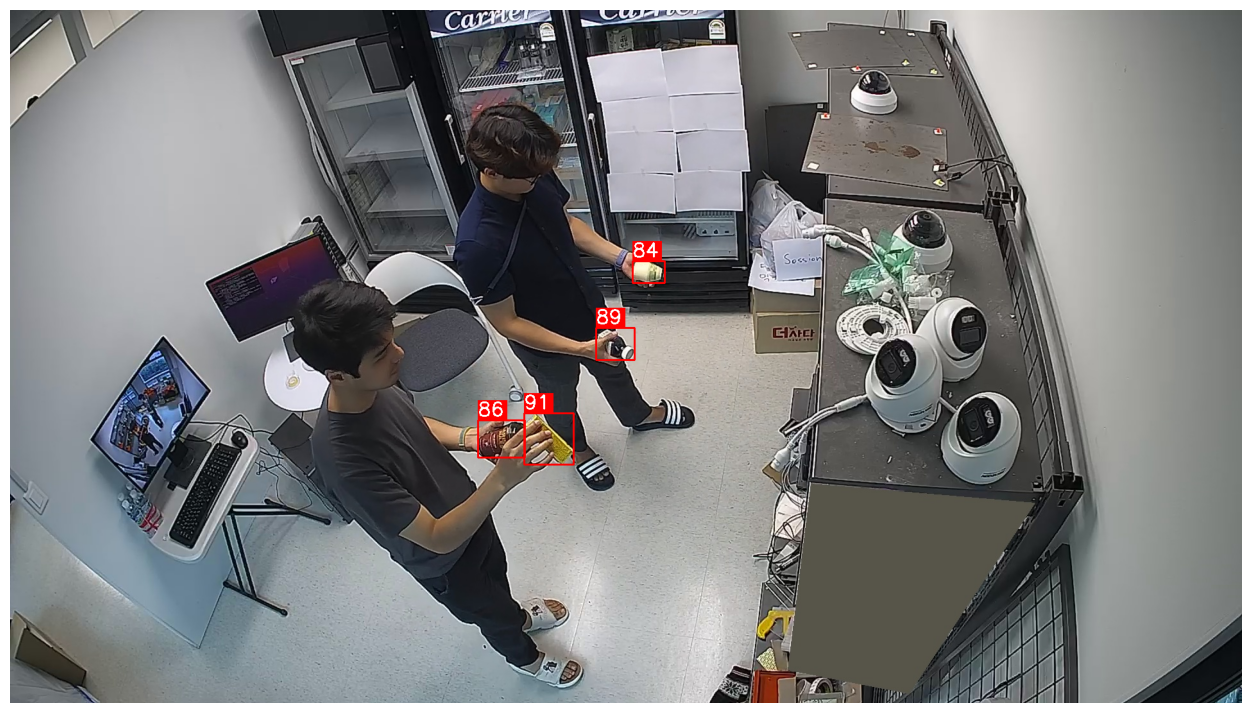

In [80]:

visualize(image, bboxes, cat_ids, classes)

# Albumentation 시각화

In [170]:
transform = A.Compose(
    [
        # A.HorizontalFlip(p=0.5),
        # A.CropNonEmptyMaskIfExists.apply_to_bboxes(640,640, p=1)
        A.RandomSizedBBoxSafeCrop(640,640,p=1),
        # A.RandomCropNearBBox(max_part_shift=0.3, p=1)
        # A.RandomCrop(800, 800,p=1),
        # A.CropAndPad(),
        # A.RandomCrop(1000,1000,p=1),
        # A.Resize(640,640,p=1),
        A.LongestMaxSize(640, p=1),
        A.PadIfNeeded(640,640,border_mode=cv2.BORDER_CONSTANT, value=(114/255, 114/255, 114/255), p=1),
    ],
    bbox_params=A.BboxParams(format='yolo', label_fields=['category_ids']),
)

In [171]:
# random.seed(71)
transformed = transform(image=image, bboxes=bboxes, category_ids=cat_ids)

In [172]:
transformed['image'].shape

(640, 640, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


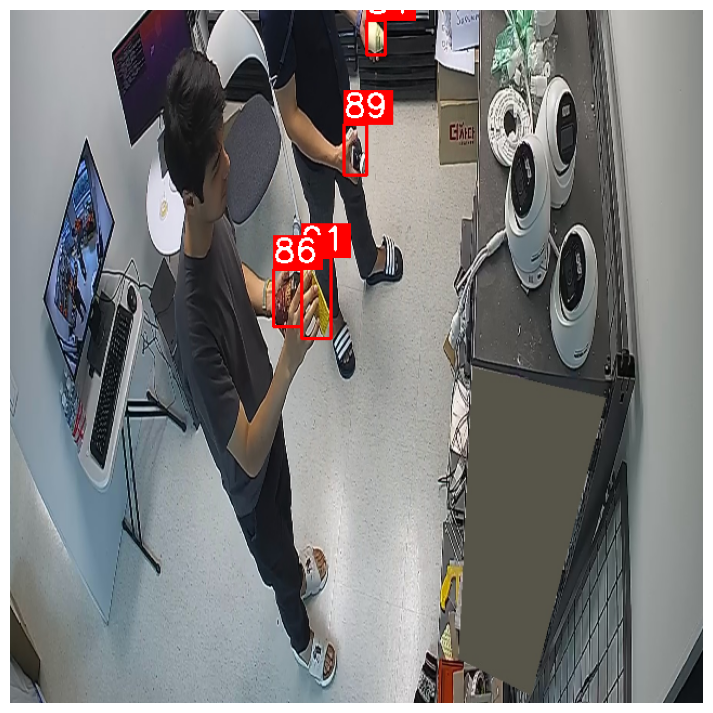

In [173]:
visualize(
    transformed['image'],
    transformed['bboxes'],
    transformed['category_ids'],
    classes,
)